In [2]:
import nltk
nltk.download('punkt')

import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize #split a string into individual words

import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Embedding, add, concatenate, dot, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
import matplotlib.pyplot as pltR

import tarfile
import re
from functools import reduce


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tarfile
path = '/content/drive/MyDrive/deepLearningDataset/babi_tasks_1-20_v1-2.tar.gz'
tar = tarfile.open(path)

In [5]:
def tokenize(sent):

    return word_tokenize(sent)

def parse_stories(lines):

    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            # reset story when line ID=1 (start of new story)
            story = []
        if '\t' in line:
            # question answer
            q, a, supporting = line.split('\t')
            # tokenize the words of question
            q = tokenize(q)
            # Provide all the sub-stories till this question
            substory = [x for x in story if x]
            # A story ends and is appended to global story data-set
            data.append((substory, q, a))
            story.append('')
        else:
            # this line is a sentence of story
            sent = tokenize(line)
            story.append(sent)
    return data

def get_stories(f):

    data = parse_stories(f.readlines())
    # lambda func to flatten the list of sentences into one list
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    # creating list of tuples for each story
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

In [6]:
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
print('Extracting stories')
# Extracting train stories
train_stories = get_stories(tar.extractfile(challenge.format('train')))
# Extracting test stories
test_stories = get_stories(tar.extractfile(challenge.format('test')))

Extracting stories for the challenge: single_supporting_fact_10k


In [7]:
vocab = set()
for story,question,answer in train_stories + test_stories:
    vocab |= set(story + question + [answer])
vocab = sorted(vocab)
vocab_size = len(vocab) +1
print(f"Lenght of Vocab  : {len(vocab)}")

Lenght of Vocab  : 21


In [8]:
word_to_idx = {w:idx for idx,w in enumerate(vocab)}
idx_to_word = {idx:w for idx,w in enumerate(vocab)}

story_maxlen = max(map(len,(x for x,_,_ in train_stories +test_stories)))
query_maxlen = max(map(len,(x for _,x,_ in train_stories +test_stories)))

In [9]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    # story vector initialization
    X = []
    # query vector initialization
    Xq = []
    # answer vector intialization
    Y = []
    for story, query, answer in data:
        # creating list of story word indices
        x = [word_idx[w] for w in story]
        # creating list of query word indices
        xq = [word_idx[w] for w in query]
        #answer
        y = np.zeros(len(word_idx) + 1)
        # creating label 1 for the answer word index
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

In [10]:
# vectorize train story, query and answer sentences using vocab
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,word_to_idx,story_maxlen,query_maxlen)
# vectorize test story, query and answer sentences vocab
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,word_to_idx,story_maxlen,query_maxlen)

In [11]:
train_epochs = 50
batch_size = 16
embed_size = 50
lstm_size = 32
dropout_rate = 0.30

In [12]:

# Pad the question sequences to match the story sequence length
queries_train_padded = pad_sequences(queries_train, maxlen=story_maxlen, padding='post', truncating='post')
queries_test_padded = pad_sequences(queries_test, maxlen=story_maxlen, padding='post', truncating='post')

# story and question input
input_sequence = Input(shape=(story_maxlen,))
question = Input(shape=(story_maxlen,))

# Embedding layer for the story
input_encoder = Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=story_maxlen)(input_sequence)

# Embedding layer for the question
question_encoder = Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=story_maxlen)(question)

# Combine story and question embeddings (concatenate)
merged = concatenate([input_encoder, question_encoder])

# LSTM layer to process the combined sequences
lstm_out = LSTM(lstm_size, dropout=dropout_rate, recurrent_dropout=dropout_rate)(merged)

# Dense layer for output (softmax for classification)
output = Dense(vocab_size, activation='softmax')(lstm_out)

# Create the model
model = Model(inputs=[input_sequence, question], outputs=output)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


#training the model
history = model.fit([inputs_train, queries_train_padded], answers_train,
                    batch_size=batch_size,
                    epochs=train_epochs,
                    validation_data=([inputs_test, queries_test_padded], answers_test))

# Save the trained model
model.save('model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.2265 - loss: 1.9356 - val_accuracy: 0.5290 - val_loss: 1.4364
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.5170 - loss: 1.4028 - val_accuracy: 0.5380 - val_loss: 1.2518
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.5276 - loss: 1.2351 - val_accuracy: 0.5250 - val_loss: 1.1581
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.5315 - loss: 1.1431 - val_accuracy: 0.5270 - val_loss: 1.1144
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.5327 - loss: 1.1097 - val_accuracy: 0.5320 - val_loss: 1.1102
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5230 - loss: 1.0984 - val_accuracy: 0.5170 - val_loss: 1.0969
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.5266 - loss: 1.0787 - val_accuracy: 0.5310 - val_loss: 1.0924
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5297 - loss: 1.0682 - 

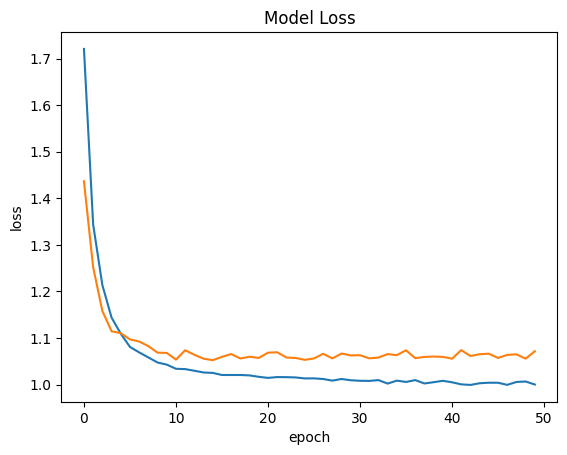

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel("loss")
plt.xlabel('epoch')
plt.show()

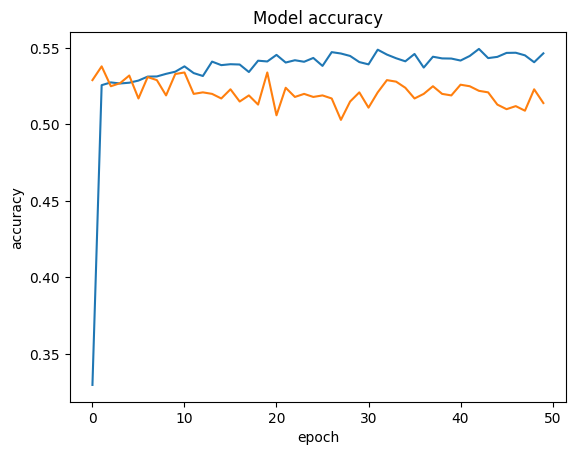

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel("accuracy")
plt.xlabel('epoch')
plt.show()

In [15]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=query_maxlen))
question_encoder.add(Dropout(dropout_rate))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)
print('Response shape', response)

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Input sequence: <KerasTensor shape=(None, 68), dtype=float32, sparse=False, name=keras_tensor_7>
Question: <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_8>
Input encoded m <KerasTensor shape=(None, 68, 50), dtype=float32, sparse=False, name=keras_tensor_12>
Input encoded c <KerasTensor shape=(None, 68, 4), dtype=float32, sparse=False, name=keras_tensor_16>
Question encoded <KerasTensor shape=(None, 4, 50), dtype=float32, sparse=False, name=keras_tensor_20>
(None, 68, 4)
Match shape <KerasTensor shape=(None, 68, 4), dtype=float32, sparse=False, name=keras_tensor_22>
Response shape <KerasTensor shape=(None, 4, 68), dtype=float32, sparse=False, name=keras_tensor_24>
Answer shape <KerasTensor shape=(None, 4, 118), dtype=float32, sparse=False, name=keras_tensor_25>


In [16]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 68)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 68, 50)         │          1,100 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 4, 50)          │          1,100 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 68, 4)          │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 68, 4)          │              0 │ dot[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 68, 4)          │             88 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 68, 4)          │              0 │ activation[0][0],      │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 4, 68)          │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4, 118)         │              0 │ permute[0][0],         │
│ (Concatenate)             │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         19,328 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 22)             │            726 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 22)             │              0 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,342 (87.27 KB)

 Trainable params: 22,342 (87.27 KB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:

# start training the model
history = model.fit([inputs_train, queries_train], answers_train,
                    batch_size=batch_size,
                    epochs=train_epochs,
                    validation_data=([inputs_test, queries_test], answers_test))

# save model
model.save('model.h5')

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.1703 - loss: 2.0307 - val_accuracy: 0.2290 - val_loss: 1.6777
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2446 - loss: 1.6862 - val_accuracy: 0.3080 - val_loss: 1.5982
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3474 - loss: 1.5882 - val_accuracy: 0.4240 - val_loss: 1.4938
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.3896 - loss: 1.5290 - val_accuracy: 0.4390 - val_loss: 1.4618
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4289 - loss: 1.4707 - val_accuracy: 0.4730 - val_loss: 1.4003
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4622 - loss: 1.4099 - val_accuracy: 0.4980 - val_loss: 1.3388
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4695 - loss: 1.3721 - val_accuracy: 0.5060 - val_loss: 1.3190
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4746 - loss: 1.3543 - val_accurac

In [18]:
for i in range(0,10):
    current_inp = test_stories[i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_to_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_pred = idx_to_word[np.argmax(current_prediction)]
    ques = " ".join(current_inp[1])
    print(f"Question : {ques} \nAnswer : {current_pred}")
    print("--------------------------------\t")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Question : Where is John ? 
Answer : hallway
--------------------------------	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Question : Where is Mary ? 
Answer : bathroom
--------------------------------	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Question : Where is Sandra ? 
Answer : kitchen
--------------------------------	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Question : Where is Sandra ? 
Answer : hallway
--------------------------------	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Question : Where is Sandra ? 
Answer : kitchen
--------------------------------	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Question : Where is Sandra ? 
Answer : hallway
--------------------------------	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Question : Where is Sandra ? 
Answer : garden
--------------------------------	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Question : Where is Daniel ? 
Answer : hallway
--------------------------------	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Question : Wh

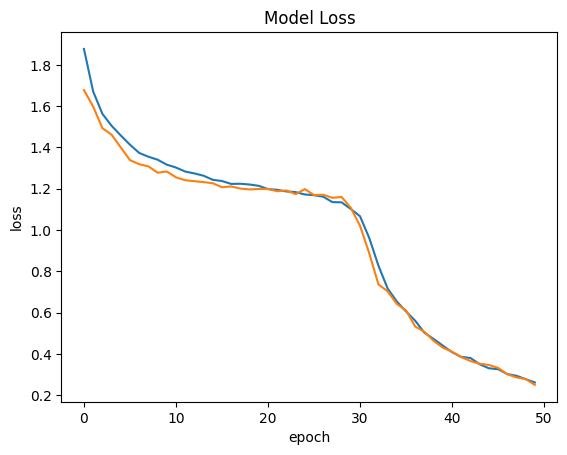

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel("loss")
plt.xlabel('epoch')
plt.show()

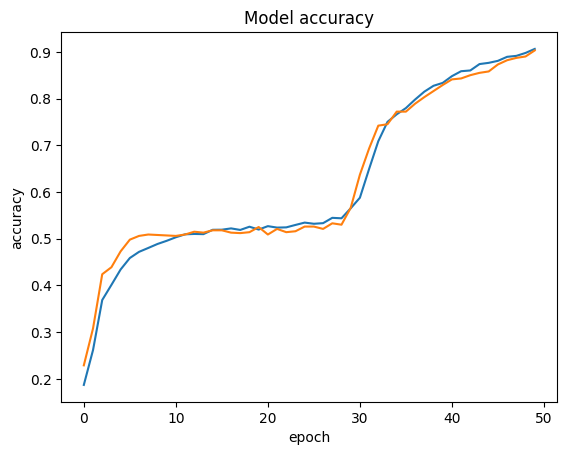

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel("accuracy")
plt.xlabel('epoch')
plt.show()

In [24]:
model.save('/content/drive/MyDrive/model.h5')